**Installing required packages**

In [ ]:
#Streamlit and pyngrok is used for web deployment of apps
!pip install streamlit
!pip install pyngrok
#nltk seems to be the common package for NLP
!pip install nltk
#We can create TCP tunnels to host our client server applications on the internet using this tool ngrok.com
#I have created an account in ngrok.com Saas application in the free-tier. The only disadvantage being we can't have custom domain names for our web apps

**Importing all the required packages**

In [ ]:
#We will do our analysis here and later migrate to app.py
#importing all required packages
import pandas as pd
import seaborn as sns
import streamlit as st
from pyngrok import ngrok
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#I am trying to use Naive-based ML model for predicting false messages
#Packages for text processing and normalization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Wireframing our front-end
#IMPORTANT NOTE: If streamlit does not work the first time, restart runtime from colab notebook menu above
%%writefile app.py
import streamlit as st
PAGE_CONFIG = {"page_title":"NLP Sentiment Analysis","page_icon":":smiley:","layout":"centered"}
st.beta_set_page_config(**PAGE_CONFIG)


def main():
  st.title("Real or False alarms? NLP with Disaster tweets")
  menu=["Introduction","Descriptive Analytics","Inquisitive Analytics","Predictive Analytics","Prescriptive Analytics"]
  choice=st.sidebar.selectbox('Menu',menu)
  if choice=="Introduction":
    st.subheader("Introduction to the Project")

  elif choice=="Descriptive Analytics":
    st.subheader("Exploratory Data Analysis")
  elif choice=="Inquisitve Analytics":
    st.subheader("Hypothesis Tests")
  elif choice=="Predictive Analytics":
    st.subheader("Construction of NLP Models")
  else:
    st.subheader("Our recommendations and future scope")
  
if __name__ == '__main__':
	main()

Overwriting app.py


In [ ]:
#Our Auth Token, will be different for other users who would want to deploy our app from here. The below provided is my auth token which we can use.
!ngrok authtoken

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
#Starting our web application in the background
!streamlit run app.py &>/dev/null&

In [ ]:
#This is the public URL which anyone can access to see our web application.
#Currently not secured with SSL certificate
#8501 is the port where our app will run
publicURL = ngrok.connect(port='8501')
publicURL

2020-08-31 09:57:05.439 INFO    pyngrok.process: ngrok process starting: 2402
2020-08-31 09:57:05.456 INFO    pyngrok.process: t=2020-08-31T09:57:05+0000 lvl=info msg="no configuration paths supplied"

2020-08-31 09:57:05.458 INFO    pyngrok.process: t=2020-08-31T09:57:05+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

2020-08-31 09:57:05.459 INFO    pyngrok.process: t=2020-08-31T09:57:05+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

2020-08-31 09:57:05.461 INFO    pyngrok.process: t=2020-08-31T09:57:05+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040

2020-08-31 09:57:06.269 INFO    pyngrok.process: t=2020-08-31T09:57:06+0000 lvl=info msg="tunnel session started" obj=tunnels.session

2020-08-31 09:57:06.271 INFO    pyngrok.process: t=2020-08-31T09:57:06+0000 lvl=info msg="client session established" obj=csess id=eb66bad3c315

2020-08-31 09:57:06.279 INFO    pyngrok.process: ngrok process has 

'http://8269428ac0d8.ngrok.io'

In [ ]:
#To stop our process tunnels - VERY IMPORTANT
ngrok.kill()

2020-08-31 09:58:23.261 INFO    pyngrok.process: Killing ngrok process: 2402


**Loading Training Set**

In [ ]:
#Note: To load datasets, we have to mount our files from gDrive or make use of the .upload() from google.colab to take it from local files
from google.colab import files
uploaded = files.upload()

Saving train.csv to train (1).csv


In [ ]:
NLP_sentiment_training_set=pd.read_csv('train.csv')
NLP_sentiment_training_set.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


**Exploratory Data Analysis**

In [ ]:
NLP_sentiment_training_set[NLP_sentiment_training_set['keyword'].notnull()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7578,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0


In [ ]:
#The 5 keywords of distress calls
NLP_sentiment_training_set['keyword'].value_counts().head(5)

fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
Name: keyword, dtype: int64

In [ ]:
NLP_sentiment_training_set['keyword'].value_counts().tail(5)

forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, dtype: int64

In [ ]:
#Distribution of real and false alarms
#where 0 is false alarm and 1 is true alarm
NLP_sentiment_training_set['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
NLP_sentiment_training_set['location'].value_counts().head(5)

USA              104
New York          71
United States     50
London            45
Canada            29
Name: location, dtype: int64

In [ ]:
NLP_sentiment_training_set['location'].value_counts().tail(5)

Waco, Texas                       1
Freeport Ny                       1
Manchester, The World, England    1
emily | helen | shelley           1
Amarillo                          1
Name: location, dtype: int64

In [ ]:
NLP_sentiment_training_set['messageLength']=NLP_sentiment_training_set['text'].apply(len)
NLP_sentiment_training_set.head(5)

,id,keyword,location,text,target,messageLength
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


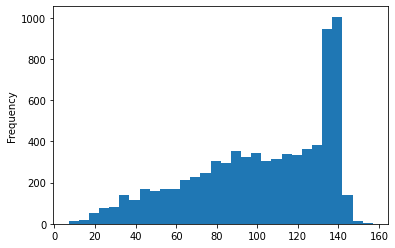

In [ ]:
NLP_sentiment_training_set['messageLength'].plot.hist(bins=30)

In [ ]:
NLP_sentiment_training_set['messageLength'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: messageLength, dtype: float64

In [ ]:
#wanted to explore the longest text
NLP_sentiment_training_set[NLP_sentiment_training_set['messageLength']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

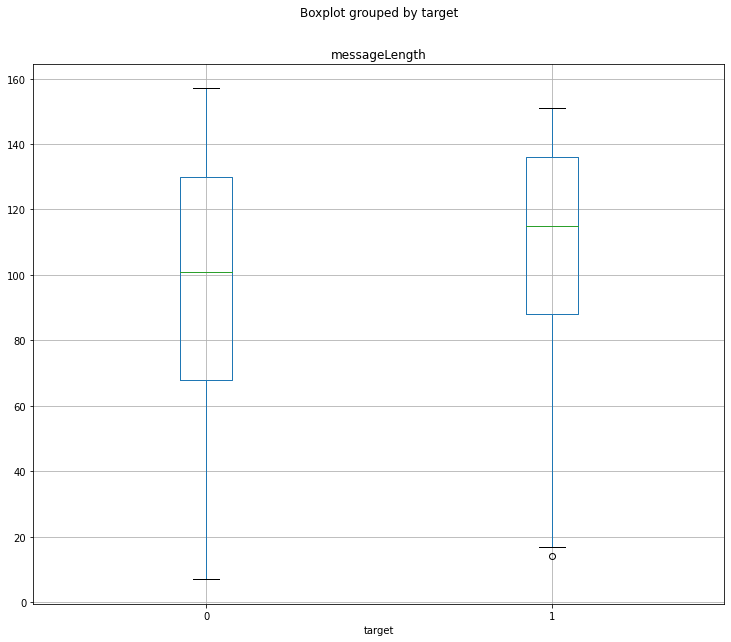

In [ ]:
NLP_sentiment_training_set.boxplot(column='messageLength',by='target',figsize=(12,10))
#true alarms tend to have more average characters

Text preprocessing and normalization. 
Note: This is just the simple normalization method. We have multiple modes such as stemming and lemmatization that we can explore

In [ ]:
#message processing and cleaning
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
def text_process(message):
  """
  1. remove punctuation
  2. remove stop words
  3. return list of clean words
  """
  noPunctuation = [char for char in message if char not in string.punctuation]
  noPunctuation = ''.join(noPunctuation)
  return [word for word in noPunctuation.split() if word.lower() not in stopwords.words('english')]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#tokenization of first 5 words
NLP_sentiment_training_set['text'].head(5).apply(text_process)

0    [Deeds, Reason, earthquake, May, ALLAH, Forgiv...
1        [Forest, fire, near, La, Ronge, Sask, Canada]
2    [residents, asked, shelter, place, notified, o...
3    [13000, people, receive, wildfires, evacuation...
4    [got, sent, photo, Ruby, Alaska, smoke, wildfi...
Name: text, dtype: object

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(NLP_sentiment_training_set['text'])

In [ ]:
print(len(bow_transformer.vocabulary_))

26473


In [ ]:
trainMessages_bow = bow_transformer.transform(NLP_sentiment_training_set['text'])

In [ ]:
print('Shape of Sparse Matrix:', trainMessages_bow.shape)

Shape of Sparse Matrix: (7613, 26473)


In [ ]:
sparcity = (100.0*trainMessages_bow.nnz / (trainMessages_bow.shape[0]*trainMessages_bow.shape[1]))
print('Sparcity: {}'.format(sparcity))

Sparcity: 0.037216627541309645


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(trainMessages_bow)
trainMessages_tfidf = tfidf_transformer.transform(trainMessages_bow)

In [ ]:
falseAlarmDetectionModel = MultinomialNB().fit(trainMessages_tfidf,NLP_sentiment_training_set['target'])
trainPred = falseAlarmDetectionModel.predict(trainMessages_tfidf)

In [ ]:
#Pipeline is a class with all the text operations as methods
pipeline = Pipeline([
                     ('bow',CountVectorizer(analyzer=text_process)),
                     ('tfidf',TfidfTransformer()),
                     ('classifier',MultinomialNB())
])

**Loading Test data**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test (1).csv


In [ ]:
NLP_sentiment_test_set=pd.read_csv('test.csv')
NLP_sentiment_test_set.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
pipeline.fit(NLP_sentiment_training_set['text'],NLP_sentiment_training_set['target'])
predictions = pipeline.predict(NLP_sentiment_test_set['text'])
NLP_sentiment_test_set['target']=predictions

In [ ]:
resultOutputDf = NLP_sentiment_test_set[['id','target']]
resultOutputDf['target'].value_counts()

0    2223
1    1040
Name: target, dtype: int64

In [ ]:
resultOutputDf

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
